In [16]:
import pandas as pd

In [17]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
import numpy as np
import json
import torch

In [18]:
len('Зашли в"аппетит" случайно.Не смотря на то,что был будний день( вторник 14 сентября) и достаточно много народа, все же решили остаться.нас ')

138

In [19]:
data = pd.read_csv('train_data.csv',  header=0, names = ['id', 'text', 'sentence', 'word', 'lemma', 'start', 'end', 'aspect', 'sentiment'])

In [20]:
data

,id,text,sentence,word,lemma,start,end,aspect,sentiment
0,25709,"Были 1 февраля. Я второй раз, подруга - первый...",Были 1 февраля.,Были,быть,0,4,O,O
1,25709,"Были 1 февраля. Я второй раз, подруга - первый...",Были 1 февраля.,1,1,5,6,O,O
2,25709,"Были 1 февраля. Я второй раз, подруга - первый...",Были 1 февраля.,февраля,февраль,7,14,O,O
3,25709,"Были 1 февраля. Я второй раз, подруга - первый...",Были 1 февраля.,.,.,14,15,O,O
4,25709,"Были 1 февраля. Я второй раз, подруга - первый...","Я второй раз, подруга - первый.",Я,я,16,17,O,O
...,...,...,...,...,...,...,...,...,...
35406,32859,20 октября отмечали день рождения нашей фирмы ...,С уважением Виктория и FITNESS Land))))))),),),1103,1104,O,O
35407,32859,20 октября отмечали день рождения нашей фирмы ...,С уважением Виктория и FITNESS Land))))))),),),1104,1105,O,O
35408,32859,20 октября отмечали день рождения нашей фирмы ...,С уважением Виктория и FITNESS Land))))))),),),1105,1106,O,O
35409,32859,20 октября отмечали день рождения нашей фирмы ...,С уважением Виктория и FITNESS Land))))))),),),1106,1107,O,O


In [21]:
set(data.aspect)

{'Food', 'Interior', 'O', 'Price', 'Service', 'Whole'}

In [22]:
data_for_train = []
lemms = list(data['lemma'])
asps = list(data['aspect'])
#first_el = 'День 8-го марта прошёл, можно и итоги подвести.'
first_el = list(data.sentence)[0]
one_sentence = []
one_aspect = []
for i, el in enumerate(data.sentence):
    if el != first_el:
        data_for_train.append((one_sentence, one_aspect))
        one_sentence = []
        one_aspect = []
        first_el = el
    one_sentence.append(lemms[i])
    one_aspect.append(asps[i])
data_for_train.append((one_sentence, one_aspect))

In [23]:
data_for_train[-10]

(['Судак',
  'просто',
  'сказка',
  ',',
  'очень',
  'вкусный',
  'и',
  'красивый',
  'и',
  'весь',
  'коллектив',
  'быть',
  'просто',
  'в',
  'восторг',
  '.'],
 ['Food',
  'O',
  'O',
  'O',
  'O',
  'Food',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [24]:
data_for_train[-20]

(['?',
  'да',
  'уж',
  ')',
  'Кухня',
  ':',
  'кушать',
  'японский',
  'кухня',
  ',',
  'вкусный',
  'еда',
  'и',
  'немаленький',
  'порция',
  ',',
  'подача',
  'обычный',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'Food',
  'O',
  'Food',
  'Food',
  'Food',
  'O',
  'O',
  'Food',
  'O',
  'O',
  'Food',
  'O',
  'Food',
  'O',
  'O'])

In [25]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [46]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix:
            idxs.append(to_ix[w])
        else:
            idxs.append(random.randint(0, 3000))
    
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [27]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [41]:
len(word_to_ix)

3449

In [29]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 300
HIDDEN_DIM = 32

# Make up some training data
training_data = data_for_train

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {'O':0, 'Food':1, 'Interior':2, 'Price':3, 'Service':4, 'Whole':5, '<START>':6, '<STOP>':7}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
test_f1 = []
losses_train = []
# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(7):
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)
        losses_train.append(loss)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

# Check predictions after training


100%|██████████████████████████████████████████████████████████████████████████████| 2388/2388 [01:36<00:00, 24.84it/s]


In [ ]:
set(data.aspect)

In [ ]:
len(word_to_ix)

In [33]:
import random

In [30]:
test_data = pd.read_csv('test_data.csv',  header=0, names = ['id', 'text', 'sentence', 'word', 'lemma', 'start', 'end', 'aspect', 'sentiment'])

In [63]:
test_data

,id,text,sentence,word,lemma,start,end,aspect,sentiment
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...","Зашли в""аппетит"" случайно.",Зашли,зайти,0,5,O,O
1,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...","Зашли в""аппетит"" случайно.",в,в,6,7,O,O
2,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...","Зашли в""аппетит"" случайно.","""","""",7,8,Whole,neutral
3,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...","Зашли в""аппетит"" случайно.",аппетит,аппетит,8,15,Whole,neutral
4,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...","Зашли в""аппетит"" случайно.","""","""",15,16,Whole,neutral
...,...,...,...,...,...,...,...,...,...
11821,11770,"Была пару раз в пабе, очень понравилось. Вкусн...","В общем, ресторан высокого уровня.",",",",",1005,1006,O,O
11822,11770,"Была пару раз в пабе, очень понравилось. Вкусн...","В общем, ресторан высокого уровня.",ресторан,ресторан,1007,1015,Whole,positive
11823,11770,"Была пару раз в пабе, очень понравилось. Вкусн...","В общем, ресторан высокого уровня.",высокого,высокий,1016,1024,O,O
11824,11770,"Была пару раз в пабе, очень понравилось. Вкусн...","В общем, ресторан высокого уровня.",уровня,уровень,1025,1031,O,O


In [31]:
data_for_test = []
lemms = list(test_data['lemma'])
asps = list(test_data['aspect'])
#first_el = 'День 8-го марта прошёл, можно и итоги подвести.'
first_el = list(test_data.sentence)[0]
one_sentence = []
one_aspect = []
for i, el in enumerate(test_data.sentence):
    if el != first_el:
        data_for_test.append((one_sentence, one_aspect))
        one_sentence = []
        one_aspect = []
        first_el = el
    one_sentence.append(lemms[i])
    one_aspect.append(asps[i])
data_for_test.append((one_sentence, one_aspect))

In [62]:
len(asps)

11826

In [61]:
len(data_for_test)

805

In [53]:
answers_test = []
losses_test = []
with torch.no_grad():
    for sentence, tags in tqdm(data_for_test):

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        #print(sentence_in)
        res = model(sentence_in)
        answers_test.append(res)

        loss = model.neg_log_likelihood(sentence_in, targets)
        losses_test.append(loss)


100%|████████████████████████████████████████████████████████████████████████████████| 805/805 [00:12<00:00, 66.32it/s]


In [54]:
answers_test[0]

(tensor(48.1634), [0, 0, 5, 5, 5, 0, 0])

In [39]:
#мы могли бы сказать, что мы переобучились. Но мы не переобучились -- мы можем в предсказание придуманного случайного
sentence = 'мы ходить в ресторан " армения " , горячий быть вкусно, десерт и сервис быть не очень'.split()
sentence_in = prepare_sequence(sentence, word_to_ix)
model(sentence_in)

(tensor(110.1358, grad_fn=<SelectBackward0>),
 [0, 0, 0, 5, 5, 5, 5, 0, 1, 0, 1, 1, 0, 4, 0, 0, 0])

In [21]:
print(prepare_sequence(data_for_train[-600:-598][0][1], tag_to_ix))

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 5, 0])


In [72]:
ix_to_tag = {0:'O',
 1:'Food',
 2:'Interior',
 3:'Price',
 4:'Service',
 5:'Whole'}

In [59]:
len(answers_test)

805

In [58]:
len(test_data['aspect'])

11826

In [76]:
answers_test[0][1]

[0, 0, 5, 5, 5, 0, 0]

In [77]:
ans_all = []
pre_all = []
ans = []
pre = []
for i, el in enumerate(answers_test):
    pre_all.extend(el[1])
    #ans_all.extend(prepare_sequence(data_for_train[-600:-598][0][1], tag_to_ix)))
    #ans_all.extend(el)
    #pre.append(prepare_sequence(answers_test[i][1], tag_to_ix))
    #ans.append(el)

In [79]:
ans_all = prepare_sequence(test_data['aspect'], tag_to_ix)

In [66]:
len(test_data['aspect'])

11826

In [67]:
test_data['aspect'][0]

'O'

In [65]:
len(pre_all)

11826

In [80]:
from sklearn.metrics import *

In [81]:
accuracy_score(ans_all, pre_all)

0.9314222898697785

In [82]:
print(f1_score(ans_all, pre_all, average='weighted'))

0.9286456056083136


In [83]:
import matplotlib.pyplot as plt

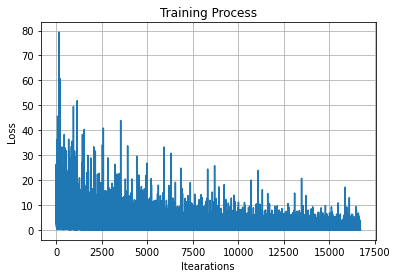

In [84]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot([loss.item() for loss in losses_train])

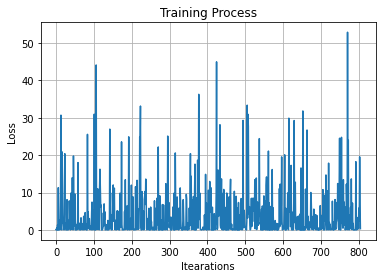

In [85]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot([loss.item() for loss in losses_test])

In [86]:
to_aspect = [ix_to_tag[i] for i in pre_all]

In [87]:
to_aspect

['O',
 'O',
 'Whole',
 'Whole',
 'Whole',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Service',
 'Service',
 'O',
 'O',
 'O',
 'Service',
 'O',
 'Service',
 'Service',
 'Service',
 'O',
 'Service',
 'Service',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Service',
 'O',
 'Service',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Food',
 'Food',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Price',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Whole',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Price',
 'O',
 'O',
 'O',
 'Service',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'Whole',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',


In [ ]:
test_data['aspect'] = to_aspect

In [93]:
test_data.to_csv('pred_test.csv', index=None, sep='\t')

In [29]:
model

BiLSTM_CRF(
  (word_embeds): Embedding(17, 300)
  (lstm): LSTM(300, 16, bidirectional=True)
  (hidden2tag): Linear(in_features=32, out_features=5, bias=True)
)

In [92]:
test_data[test_data.id == 11770][-50:]

,id,text,sentence,word,lemma,start,end,aspect,sentiment
11776,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,поводу,повод,757,763,O,O
11777,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,немного,немного,764,771,O,O
11778,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,беспокоился,беспокоиться,772,783,O,O
11779,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,",",",",783,784,O,O
11780,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,не,не,785,787,O,O
11781,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,поменяли,менять,788,796,O,O
11782,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,ли,ли,797,799,O,O
11783,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,повара,повар,800,806,Food,positive
11784,11770,"Была пару раз в пабе, очень понравилось. Вкусн...",Когда пришли второй раз муж по этому поводу не...,?,?,806,807,O,O
11785,11770,"Была пару раз в пабе, очень понравилось. Вкусн...","Но когда убедился, что стейк сделан также здор...",Но,но,808,810,O,O
